# Tutorial 6: Galactic Binaries & RJMCMC

In the sixth tutorial, we will examine Galactic Binary waveforms. We will then use them in fixed-dimensional MCMC and then in RJMCMC. We use RJMCMC to perform model selection on the number of sources in the data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *
from lisatools.sensitivity import get_sensitivity

## Task 1: Build and plot a Galacic Binary waveform using `GBGPU`

We will start by generating Galactic Binary waveforms with `GBGPU`. Pick reasonable parameters, build a waveform and plot it against the LISA A channel TDI Sensitivity Curve (`A1TDISens`) in the characteristic strain representation. You can access the information after waveform generation as attributes on the class. This may be updated in the future.

Useful documentation:
* [GBGPU](https://mikekatz04.github.io/GBGPU/html/user/main.html#gbgpu.gbgpu.GBGPU)

In [2]:
# imports
from gbgpu.gbgpu import GBGPU

In [3]:
gb = GBGPU()

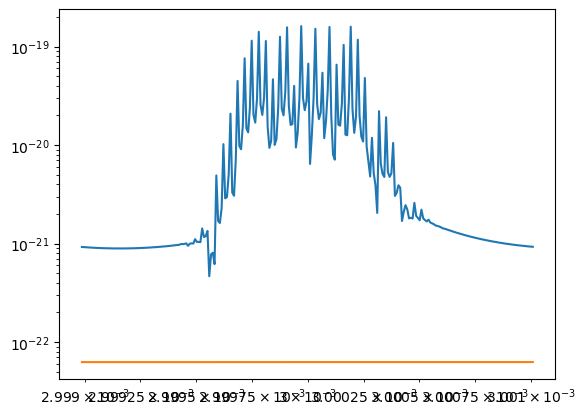

In [16]:
gb_params = dict(
    amp = 2e-23,  # amplitude
    f0 = 3e-3,  # f0
    fdot = 7.538331e-18,  # fdot
    fddot = 0.0, # fddot
    phi0 = 0.1,  # initial phase
    iota = 0.2,  # inclination
    psi = 0.3,  # polarization angle
    lam = 0.4,  # ecliptic longitude
    beta = 0.5  # ecliptic latitude
)

Tobs = 4 * YRSID_SI

gb.run_wave(**gb_params, N=256, T=Tobs)

fig, ax = plt.subplots()
ax.plot(gb.freqs[0], gb.freqs[0]*np.abs(gb.A[0]))
ax.plot(gb.freqs[0], get_sensitivity(gb.freqs[0], sens_fn="A1TDISens", return_type="char_strain"))
ax.set_yscale("log")
ax.set_xscale("log")

# Signal we are trying to find
data = gb

In [10]:
#fig, ax = plt.subplots()

#gb.run_wave(**gb_params, N=1_000, T=Tobs)

#ax.plot(gb.freqs[0], gb.freqs[0]*np.abs(gb.A[0]))
#ax.plot(gb.freqs[0], get_sensitivity(gb.freqs[0], sens_fn="A1TDISens", return_type="char_strain"))
#ax.set_yscale("log")
#ax.set_xscale("log")

## Task 2: Run an MCMC over a single GB source

Run a fixed-dimensional MCMC run with a chosen GB source. Fix the sky location for now to simplify the problem computationally (this is especially important for the next section on RJ with GBs). So, you will sample over 6 of the 8 parameters. Discuss or think about reasonable priors for these parameters and how you would determine that. For simplicity, we recommend using tightly (but not too tightly) bound uniform distributions for this example setup.

There is a faster `get_ll` method on the `GBGPU` class. However, it may be easier to use the full `AnalysisContainer` setup. This will make the RJ part more straight forward, but is not actually ideal for fixed-dimensional MCMC on GBs. 

AFter the run is complete, plot the posterior distribution with `chainconsumer` or `corner`. 

In [6]:
from eryn.prior import uniform_dist, ProbDistContainer
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray
from lisatools.sensitivity import AE1SensitivityMatrix
from eryn.ensemble import EnsembleSampler
from eryn.state import State

In [23]:
priors = {"gb": ProbDistContainer({
    0: uniform_dist(1e-23, 1e-21), #Amplitude chr_strain units
    1: uniform_dist(0.00299995, 0.00300005), # frequency (Hz), narrow band
    2: uniform_dist(1e-18, 1e-17), # fdot
    3: uniform_dist(0.0, 2 * np.pi), # phi0 (initial phase, radians)
    4: uniform_dist(0.0, np.pi), # iota (inclination, radians)
    5: uniform_dist(0.0, np.pi), # psi (polarization, radians)
    # Sky location specifically excepted?
})}



def likelihood(sampler_gb_params, gb, data, Tobs, dt, N_wave):
    amp = sampler_gb_params[0]
    f = sampler_gb_params[1]
    fdot = sampler_gb_params[2]
    fddot = 0.0
    phi0 = sampler_gb_params[3]
    iota = sampler_gb_params[4]
    psi = sampler_gb_params[5]


    lam = 0.4
    beta = 0.5

    # wave from our sampler
    gb.run_wave(amp, f, fdot, fddot, phi0, iota, psi, lam, beta, T=Tobs, dt=dt, N=N_wave)
    A = gb.A[0] - data.A[0]
    E = gb.E[0] - data.E[0]

    
    # Construct an Analysis Container
    data_res = DataResidualArray(np.array([A,E]), f_arr=gb.freqs[0])
    sense_mat = AE1SensitivityMatrix(data_res.f_arr)
    analysis = AnalysisContainer(data_res, sense_mat)

    return analysis.likelihood(source_only = True)

nwalkers = 30
ndim = 6
ntemps = 5


# gb object for sampler to use
gb = GBGPU()
dt = 10
N_wave = 256

sampler = EnsembleSampler(nwalkers=nwalkers, 
                ndims=ndim, 
                log_like_fn=likelihood, 
                priors = priors["gb"], 
                args = [gb, data, Tobs, dt, N_wave],
                tempering_kwargs={"ntemps":ntemps, "Tmax": np.inf})


coords = priors["gb"].rvs(size=(ntemps, nwalkers))

#print(coords)
#print(coords.shape)

initial_state = State(coords)
                                      

sampler.run_mcmc(initial_state= initial_state, nsteps=5_000, burn=1_000)


## Task 3: RJ with GBs

Our final task will be to run RJMCMC on a few close Galactic Binaries. The key component here is the "global" Likelihood function. Work to build a function that takes from Eryn and adjustable length array of templates to be summed into a global template prior to the Likelihood computations. This will be a bit tedious, but is very important for understanding this process. 

There is another nuance in this problem that must be dealt with to get this all to work. In the fixed-dimensional case with one binary, the default stretch proposal is effectively invariant to the scale along each dimension as there is no mixing of dimensional information when making a  proposal, $\vec{Y} = \vec{X}_j + z\left(\vec{X}_i - \vec{X}_j\right)$. The default `GaussianMove` that we used in tutorial 5 requires an inversion of the covariance matrix. If we sample in the parameters we used above ($A$, $f_0$, $\dot{f}$, etc.), the scale differences between parameters will cause numerical issues with matrix inversion and multiplication. 

There is a small variety of ways to deal with this. Here are two possibilities:

1) You can log scale and reduce each parmeter so they are all of order 1. This would involve changing the priors and making sure you include this conversion in your Likelihood function. You can use `eryn.utils.TransformContainer` to do this conversion if you would like.
2) You can create your own proposal where you assume a diagonal covariance and generate the information yourself. In the answer key, I have chosen to take this route for this example. **Hint**: the Eryn tutorial has an example of this. 

If you really want to get fancy: 

In the setup described, every source that currently has `inds=True` will be moved together. That means, if a given walker has 5 sources, all 5 sources' parameters will change at the same time. This can hurt the acceptance fraction of these moves. In reality, you may want to use Gibbs sampling to sample one or a few sources at once. You can accomplish this using the `gibbs_sampling_setup` kwarg for `eryn.moves.Move`. 

Useful documentation:

* [MHMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.MHMove)
* [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#eryn.utils.TransformContainer)
* [Move](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.Move)

If you can run the sampler and confirm the Likelihoods are working, then consider this completed. The time alloted for the tutorial and the overall setup needed to run this RJ setup correclty require a lot more runtime for reasonable results. So, you can plot what comes out, but it will become more accurate as your run the sampler longer. 